# Initializer

In [2]:
import sys
sys.path.insert(0,'../src')

#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess

# print('Installing dm_control...')
# !pip install -q dm_control==1.0.8

# Use egl locally
%env MUJOCO_GL=egl
# Use osmesa on DSMLP
# %env MUJOCO_GL=osmesa
%env PYOPENGL_PLATFORM=
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite


#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# # Soccer
# from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam
# from torch.utils.tensorboard import SummaryWriter

# try out the wrappers
from acme import wrappers
from dm_control import suite
from acme import wrappers
from model import *
from utils import *
# Soft-Actor-Critic Model
from sac import *
from replay_memory import *
import argparse
import datetime
import itertools
import os
import random
import math
import pickle

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


######  Environment wrappers  ####
from dm_env import specs




from IPython.display import display, HTML

#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
# random_state = np.random.RandomState(42)
# env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})


env: MUJOCO_GL=egl
env: PYOPENGL_PLATFORM=
env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
Checking that the dm_control installation succeeded...


/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_link.py:19: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`) Passing types is deprecated in traitlets 4.1.
  super(WidgetTraitTuple, self).__init__(Instance(Widget), Unicode, **kwargs)
/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_link.py:19: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`) Passing types is deprecated in traitlets 4.1.
  super(WidgetTraitTuple, self).__init__(Instance(Widget), Unicode, **kwargs)


# Initialize the Agent

In [3]:
# load the environment
env = suite.load(domain_name="walker", task_name="walk")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)


class Args:
    env_name = 'whatever'
    policy = 'Gaussian'
    eval = True
    gamma = 0.99
    tau = 0.005
    lr = 0.0003
    alpha = 0.2
    automatic_entropy_tuning = True
    seed = 42
    batch_size = 512
    num_steps = 1000000
    hidden_size = 1024
    updates_per_step = 1
    start_steps = 10000
    target_update_interval = 1
    replay_size = 1000000
    # use the cuda to speedup
    cuda = True


args = Args()

# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
# obs_dim = sum([item.shape[0] for item in flat_obs])
obs_dim = 0
for i in flat_obs:
    try:
        obs_dim += i.shape[0]
    except IndexError:
        obs_dim += 1

# setup agent, using Soft-Actor-Critic Model
agent = SAC(obs_dim, env.action_spec(), args)
# load checkpoint - UPLOAD YOUR FILE HERE!
model_path = '../data/models/sac_checkpoint_walker_walk_batch512_hidden1024_1123_500'
agent.load_checkpoint(model_path, evaluate=True)

# pull out model
model = agent.policy
# setup hook dict
hook_dict = init_hook_dict(model)
# add hooks
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(recordtodict_hook(name=name, hook_dict=hook_dict))

Loading models from ../data/models/sac_checkpoint_walker_walk_batch512_hidden1024_1123_500


# Define Rollouts' Joints

In [4]:
WALKER_GEOM_NAMES = ['floor', 'torso', 'right_thigh', 'right_leg', 'right_foot', 'left_thigh', 'left_leg', 'left_foot']
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(WALKER_GEOM_NAMES)}

In [5]:
# for recording kinematics
total_kinematic_dict = {
    'geom_positions': []
}

frames = []
ticks = []
observations = []
rewards = []
time_step = env.reset()
while not time_step.last():  # or env.get_termination()
    # get the state
    state = get_flat_obs(time_step)
    # sample an action
    action = agent.select_action(state)
    time_step = env.step(action)
        
    camera0 = env.physics.render(camera_id=0, height=480, width=480)
    frames.append(camera0)
    # record kinematics
    kinematic_dict = get_geoms(env.physics, WALKER_GEOM_NAMES)
    total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
    # record reward
    time_step_reward = time_step.reward
    rewards.append(time_step_reward)
# save_video(frames, video_name="sac_test_video.mp4")
print("Rendering Complete!")

Rendering Complete!


In [6]:
%matplotlib inline

/home/scott/.local/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


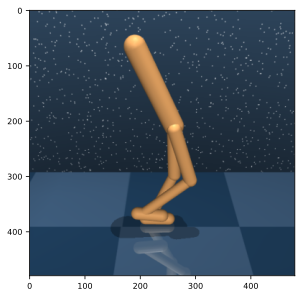

In [7]:
plt.imshow(camera0)

# TSNE Clustering of Kinemetics

In [8]:
from sklearn.manifold import TSNE

# Preproc the kinematic data
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],axis=0)

X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1, random_state=123)
trans = tsne.fit_transform(X)

/home/scott/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'goem_positions')

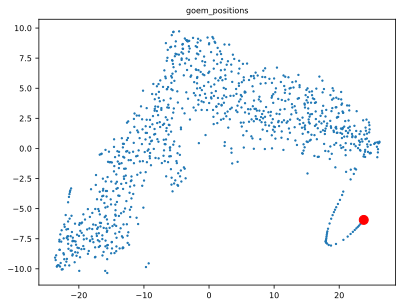

In [9]:
plt.scatter(trans[:, 0], trans[:, 1], s=2)
plt.scatter(trans[0, 0], trans[0, 1], s=80, c="r")
plt.title("goem_positions")

# Watershed Segmentation

In [58]:
%matplotlib inline

In [75]:
# to clean stuff up, given a tnse cluster in two dim, return the watershed segmentations.

def watershed_seg(X, threshould=1e-5):
    from sklearn.neighbors import KernelDensity
    from skimage.segmentation import watershed
    from scipy.interpolate import NearestNDInterpolator
    
    kde = KernelDensity(bandwidth=5, kernel="gaussian", algorithm="ball_tree")
    kde.fit(X)
    n = 100

    xv, yv = np.linspace(-30, 30, n), np.linspace(-30, 30, n)
    XX, YY = np.meshgrid(xv, yv)

    Z = np.exp(kde.score_samples(np.stack([XX.reshape(-1), YY.reshape(-1)], axis=1)))

    Z = Z.reshape(XX.shape)
    
    L = watershed(-Z)
    L[Z < threshould] = 0
    interp = NearestNDInterpolator(np.stack([XX.reshape(-1), YY.reshape(-1)], axis=1), L.reshape(-1))
    XL = interp(X)
    return XL

In [76]:
XL = watershed_seg(trans)

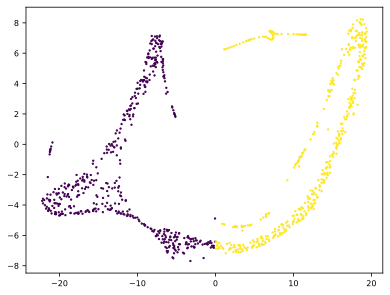

In [77]:
plt.scatter(trans[:, 0], trans[:, 1], s=2, c=XL)

# Plot it in a live loop.

In [62]:
fig = plt.figure(figsize=(9.6,1), dpi=100)
plt.text(0.5,0.5, "SAC Agent",horizontalalignment='center',
        verticalalignment='center', size=50, c='r')
plt.axis('off')
fig.canvas.draw()
title = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))


In [63]:
import matplotlib
matplotlib.use("agg")

In [64]:
batch_frames = []
for i in range(len(frames)):
    fig = plt.figure(figsize=(4.8, 4.8), dpi=100)
    plt.scatter(trans[:, 0], trans[:, 1], s=2, c=XL)
    plt.scatter(trans[i, 0], trans[i, 1], s=80, c="r")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    frame = np.hstack((frames[i], graph))
    frame = np.vstack((title, frame))
    batch_frames.append(frame)
    plt.close()
save_video(batch_frames, video_name="tsne_sac_walking_highlights_watershed.mp4")

True

# Visulize Offline (BC) Model

In [66]:
from BCNetwork import BCNetwork
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = BCNetwork(24, 6, 1024).to(device)
network.load_state_dict(
    torch.load("../data/bc_models/walker_1024_bc.pt")
)

<All keys matched successfully>

In [89]:
# for recording kinematics
total_kinematic_dict = {
    'geom_positions': []
}

frames = []
ticks = []
observations = []
rewards = []
time_step = env.reset()
while not time_step.last():  # or env.get_termination()
    state = get_flat_obs(time_step)
    # use bc network
    action = network(torch.tensor(state), device=device)
    time_step = env.step(action.cpu().detach().numpy())
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    camera0 = env.physics.render(camera_id=0, height=480, width=480)
    frames.append(camera0)
    # record kinematics
    kinematic_dict = get_geoms(env.physics, WALKER_GEOM_NAMES)
    total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
    # record reward
    time_step_reward = time_step.reward
    rewards.append(time_step_reward)
# save_video(frames, video_name="sac_test_video.mp4")
print("Rendering Complete!")

Rendering Complete!


In [90]:
from sklearn.manifold import TSNE

# Preproc the kinematic data
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],axis=0)

X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1, random_state=123)
trans = tsne.fit_transform(X)

/home/scott/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'goem_positions')

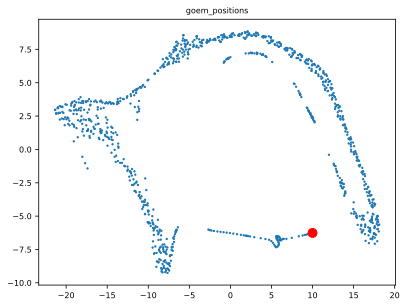

In [91]:
%matplotlib inline
plt.scatter(trans[:, 0], trans[:, 1], s=2)
plt.scatter(trans[0, 0], trans[0, 1], s=80, c="r")
plt.title("goem_positions")

In [92]:
XL = watershed_seg(trans, threshould=1e-6)

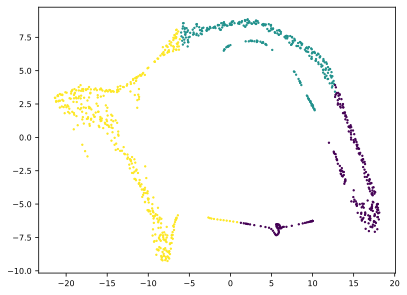

In [93]:
plt.scatter(trans[:, 0], trans[:, 1], s=2, c=XL)

In [95]:
fig = plt.figure(figsize=(9.6,1), dpi=100)
plt.text(0.5,0.5, "BC Agent",horizontalalignment='center',
        verticalalignment='center', size=50, c='r')
plt.axis('off')
fig.canvas.draw()
title = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))


In [96]:
import matplotlib
matplotlib.use("agg")
batch_frames = []
for i in range(len(frames)):
    fig = plt.figure(figsize=(4.8, 4.8), dpi=100)
    plt.scatter(trans[:, 0], trans[:, 1], s=2, c=XL)
    plt.scatter(trans[i, 0], trans[i, 1], s=80, c="r")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    frame = np.hstack((frames[i], graph))
    frame = np.vstack((title, frame))
    batch_frames.append(frame)
    plt.close()
save_video(batch_frames, video_name="tsne_bc_walking_highlights_watershed.mp4")

True